## Assignment 1 
### Anh Tu Vu a1911757

### 1. Reading datasets

#### 1.1 Loading data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from collections import Counter
import contractions
from langdetect import detect
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import gensim
from gensim.models import Word2Vec
import imblearn 
from imblearn.over_sampling import SMOTE
import spacy
import warnings
import time

In [2]:
# Read the reviews from json file
reviews = []
with open("random_30000_hotel_reviews.json", encoding="utf-8") as f:
    for line in f:
        reviews.append(json.loads(line))

# Select 3 attributes as described in the instructions and put them in 3 lists
overall_scores = [review["ratings"]["overall"] for review in reviews]
titles = [review["title"] for review in reviews]
texts = [review["text"] for review in reviews]

# Concatenate the title and text for each review
texts_concat = []
for i in range(len(titles)):
    text = titles[i] + " " + texts[i]
    texts_concat.append(text)

# Create a dataframe with the title and concatenated text
df = pd.DataFrame()
df["overall"] = overall_scores
df["text"] = texts_concat

# Show the first 5 rows
df.head(5)

,overall,text
0,1.0,“Horrible experience” First of all we got ther...
1,1.0,“Stay Away” Found Racist graffiti in the room....
2,4.0,“Great location and service” Close to Union Sq...
3,2.0,“I will never go back here again!” I had a bad...
4,1.0,“Ripped off our VISA card after departure” Aft...


#### 1.2 Cleaning data

Before proceeding further to the EDA section, I will do some intial cleaning steps for the text as follows:
- Remove non-English reviews.
- Lowercase all letters: We only care about the meaning of the words so there is no need to differentiate between upper and lowercases.
- Remove stop words: After plotting the bar chart of the most frequent words, I notice that the top words are all stop words. Since they provide no values in sentiment analysis, I will remove them here.
- Expand contractions: we'll --> we will, i'll --> i will, etc. We need to do this step here before removing non-alphanumeric characters, as doing so will change these contractions into completely different words with different meanings.
- Remove digits and words that contain digits as these do not provide any important information regarding the sentiment.

In [3]:
df.head(5)

,overall,text
0,1.0,“Horrible experience” First of all we got ther...
1,1.0,“Stay Away” Found Racist graffiti in the room....
2,4.0,“Great location and service” Close to Union Sq...
3,2.0,“I will never go back here again!” I had a bad...
4,1.0,“Ripped off our VISA card after departure” Aft...


In [4]:
def is_english(text):
    return detect(text) == "en"

# Drop the rows with non-English reviews
df["is_english"] = df["text"].progress_apply(is_english)

# Reset index after dropping the rows
df = df.reset_index(drop=True)

# Drop "is_english" column
df = df[["overall", "text"]]

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:51<00:00, 579.69it/s]


In [5]:
# Load spacy English model
nlp = spacy.load('en_core_web_sm')

# Function to preprocess text
def clean_text(text, lowercase=False, remove_stopwords=False, lemmatize=False):
    text_cleaned = ""
    # Lowercase the text
    if lowercase:
        text = text.lower()

    # Expand contractions (we'll --> we will)
    words = []
    for word in text.split(" "):
        words.append(contractions.fix(word))
    text = " ".join(words)

    # Keep only alphanumeric characters and space
    for char in text:
        if char == " ":
            text_cleaned += char
        if ord(char) >= 65 and ord(char) <= 90:
            text_cleaned += char
        if ord(char) >= 97 and ord(char) <= 122:
            text_cleaned += char
        if ord(char) >= 48 and ord(char) <= 57:
            text_cleaned += char

    # Remove digits and words that contain digits
    text_cleaned = re.sub('\w*\d\w*','', text_cleaned)

    # Remove extra white spaces
    text_cleaned = re.sub(" +", " ", text_cleaned).strip()

    # Tokenize the text
    tokens = word_tokenize(text_cleaned)
    text_cleaned = " ".join(tokens)

    # Remove stop words
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        text_cleaned = " ".join([word for word in text_cleaned.split(" ") if word not in stop_words])
    
    # Lemmatize
    if lemmatize:
        doc = nlp(text_cleaned)
        lemmatized_tokens = [token.lemma_ for token in doc]
        text_cleaned = ' '.join(lemmatized_tokens)
    
    # Return the cleaned text as a string
    return text_cleaned

# Clean the text and add them to "text_cleaned" column
df["text_cleaned"] = df["text"].progress_apply(clean_text, args=(True, True, True))

100%|██████████| 30000/30000 [05:56<00:00, 84.14it/s] 


In [6]:
# Run this cell if you want to save the cleaned data for later use

# df.to_csv("data_cleaned.csv", index=False)
# df = pd.read_csv("./data_cleaned.csv")

In [8]:
df.head(5)

,overall,text,text_cleaned
0,1.0,“Horrible experience” First of all we got ther...,horrible experience first get room book pay we...
1,1.0,“Stay Away” Found Racist graffiti in the room....,stay away find racist graffiti room request ch...
2,4.0,“Great location and service” Close to Union Sq...,great location service close union square hote...
3,2.0,“I will never go back here again!” I had a bad...,never go back bad vibe place moment walk main ...
4,1.0,“Ripped off our VISA card after departure” Aft...,rip visa card departure receive final bill lea...


In [9]:
# Split the data to training, development, and test sets
df_train = df.loc[0:9999]
df_dev = df.loc[10000:19999]
df_test = df.loc[20000:]

### 2. Exploratory Data Analysis (EDA)

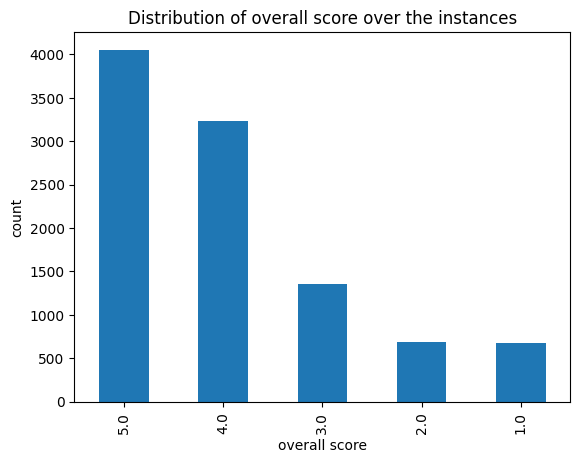

In [10]:
# Distribution of overall scores over the instances
df_dev["overall"].value_counts().plot.bar()
plt.xlabel("overall score")
plt.ylabel("count")
plt.title("Distribution of overall score over the instances")
plt.show()

We observe that the majority of the reviews are the ones with scores of 4 and 5. The other classes (1, 2, and 3) are significantly fewer, which may create imbalance between the positive and negative classes later.

In [11]:
# Find number of unique words
text = " ".join(df_dev["text_cleaned"].to_list())
words = text.split(" ")
unique_words = list(set(words))
print("Number of unique words: ", len(unique_words))

Number of unique words:  33034


Our vocabulary on the dev set contains 33034 unique words aggregated from all of the reviews. Next, let's see the most frequent words from the reviews.

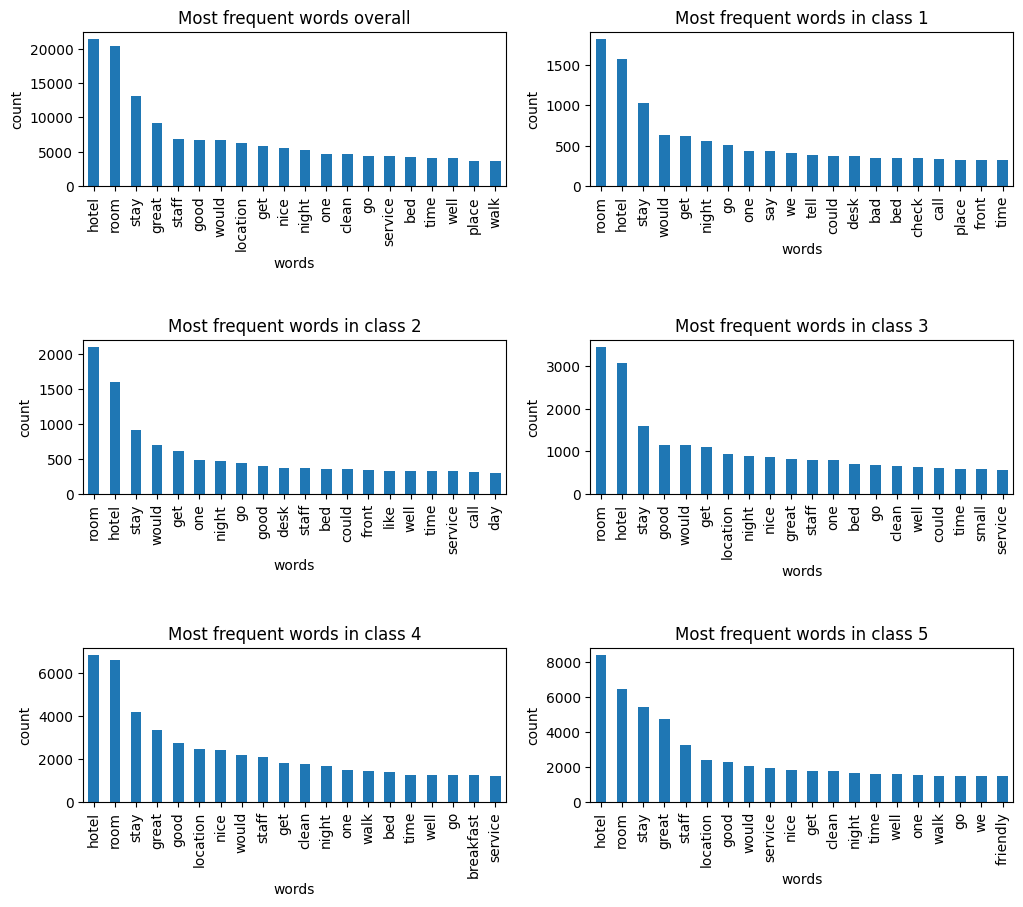

In [12]:
# Function to plot the most frequent words overall and in each class
def plot_most_frequent_words():
    plt.figure(figsize=(12, 10)) 
    plt.subplots_adjust(hspace=1)

    # Plot for the entire dev set
    plt.subplot(3, 2, 1)
    plt.title("Most frequent words overall")
    text = " ".join(df_dev["text_cleaned"].to_list())
    words = text.split(" ")
    word_counts = pd.Series(words).value_counts()
    plot = word_counts.head(20).plot.bar()
    plot.set(xlabel="words", ylabel="count")

    # Plot for each class
    for i in range(1, 6):
        plt.subplot(3, 2, i+1)
        plt.title(f"Most frequent words in class {i}")
        text = " ".join(df_dev[df_dev["overall"] == i]["text_cleaned"].to_list())
        words = text.split(" ")
        word_counts = pd.Series(words).value_counts()
        plot = word_counts.head(20).plot.bar()
        plot.set(xlabel="words", ylabel="count")
    
    plt.show()

plot_most_frequent_words()


On the entire development set, we see a lot of positive words such as "nice", "clean", "great", etc. This makes sense because reviews of 4 and 5 points are the majority. In the reviews with lower scores (1 and 2), we only see one negative word "bad" in class 1, so the negative reviews do not seem to have as strong a sentiment as that of the higher score reviews. Class 3, which is kind of in the middle, has a mixed sentiment with "well", "great" and "small". However, it seems to contain more positive words overall.

Next, we will try to see if the frequent 2-grams and 3-grams are more indicative for the sentiments.

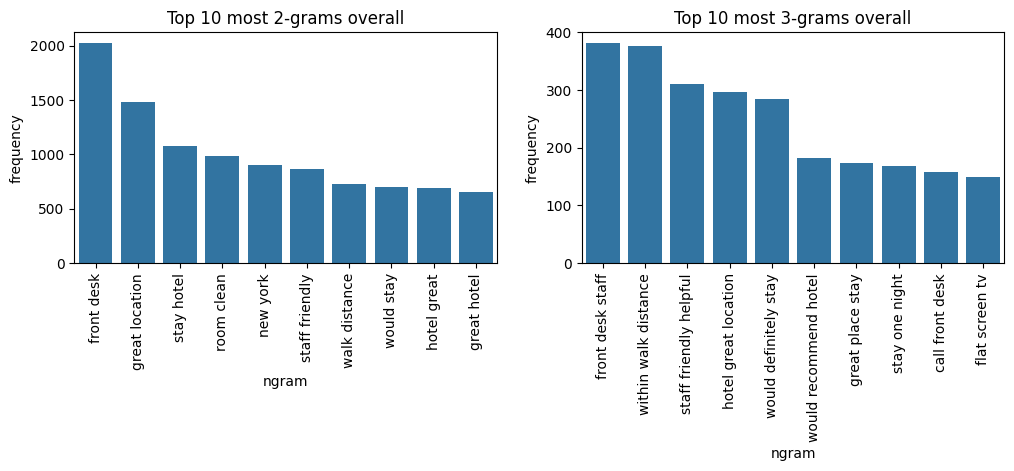

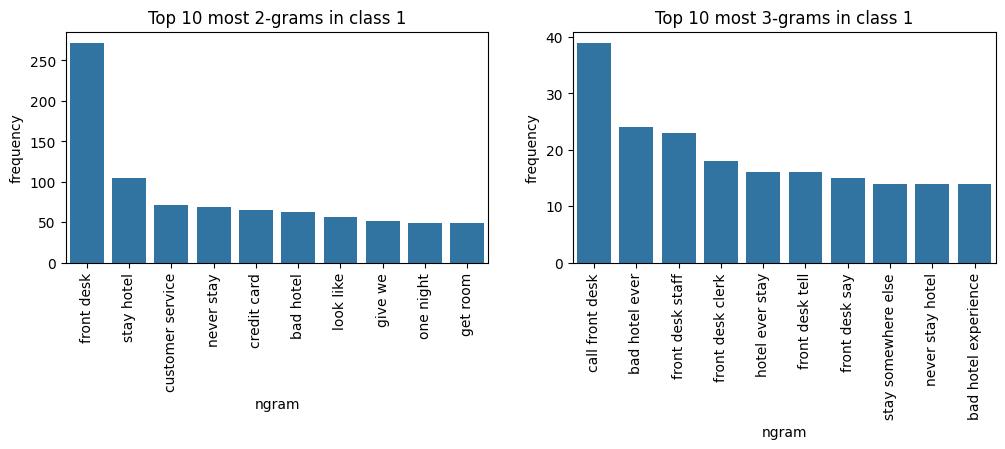

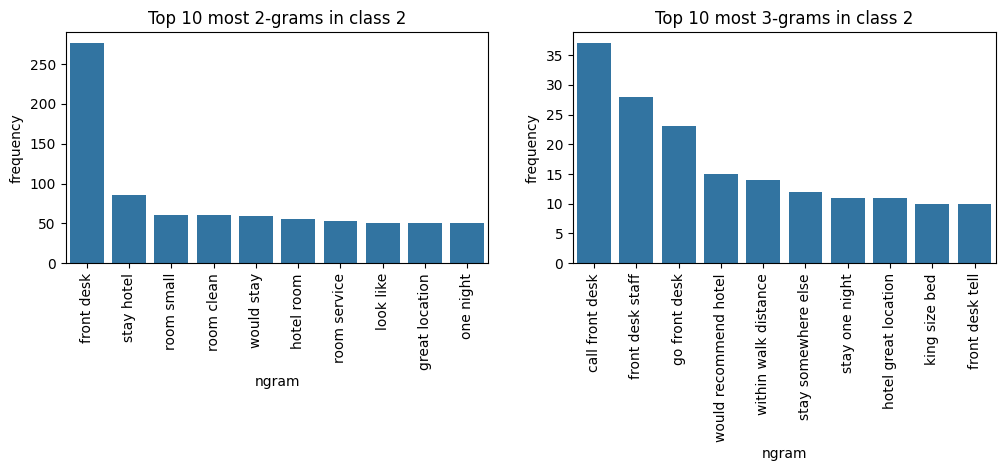

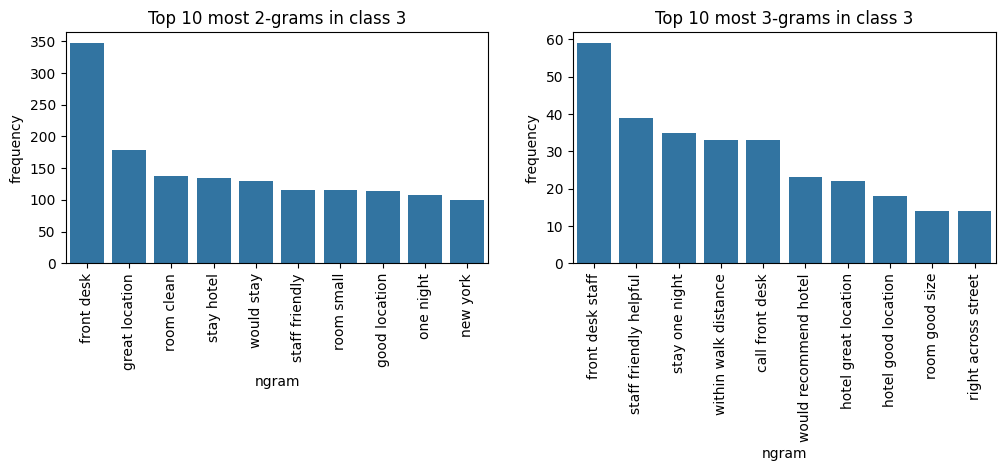

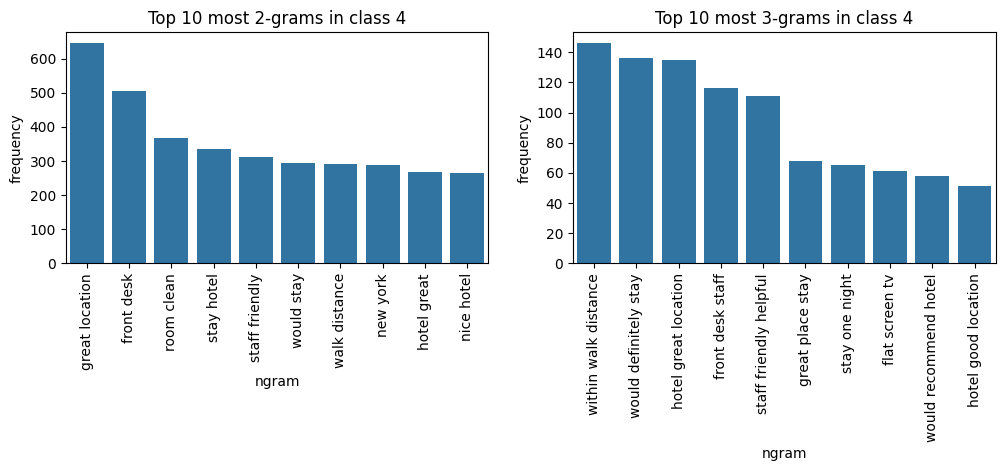

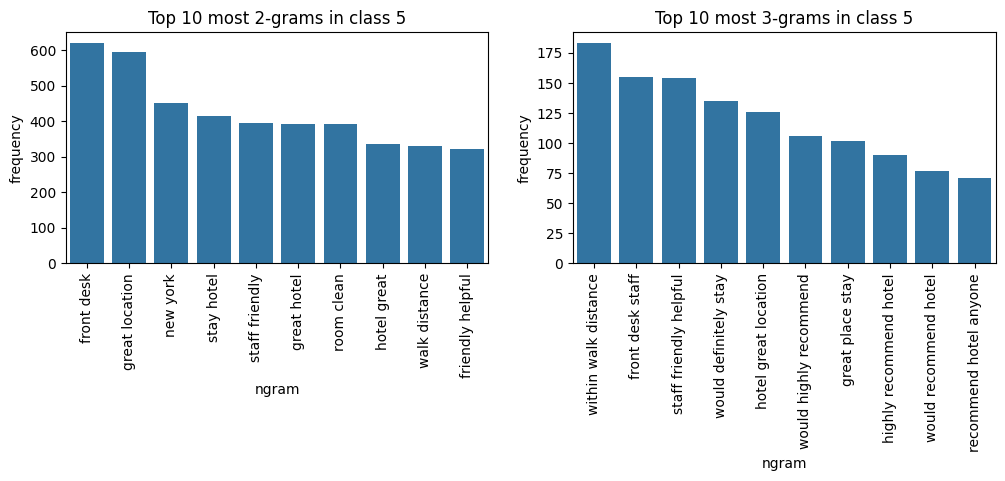

In [13]:
# Function to plot the most frequent ngrams
def plot_ngrams():
    # Set sizes for figure
    plt.figure(figsize=(12, 3)) 

    # Plot 2-grams for the dev set
    plt.subplot(1, 2, 1)
    plt.title("Top 10 most 2-grams overall")
    ngram_freq = get_ngrams_frequency(n=2, df=df_dev)
    plt1 = sns.barplot(x=ngram_freq["ngram"][:10], y=ngram_freq["frequency"][:10], orient="v")
    plt1.tick_params(axis="x", labelrotation = 90)

    # Plot 3-grams for the dev set
    plt.subplot(1, 2, 2)
    plt.title("Top 10 most 3-grams overall")
    ngram_freq = get_ngrams_frequency(n=3, df=df_dev)
    plt2 = sns.barplot(x=ngram_freq["ngram"][:10], y=ngram_freq["frequency"][:10], orient="v")
    plt2.tick_params(axis="x", labelrotation = 90)

    plt.show()

    # Loop over each class
    for i in range(1, 6):
        # Set size
        plt.figure(figsize=(12, 3)) 

        # Plot 2-grams for that class
        plt.subplot(1, 2, 1)
        plt.title(f"Top 10 most 2-grams in class {i}")
        ngram_freq = get_ngrams_frequency(n=2, df=df_dev[df_dev["overall"] == i])
        plot = sns.barplot(x=ngram_freq["ngram"][:10], y=ngram_freq["frequency"][:10], orient="v")
        plot.tick_params(axis="x", labelrotation = 90)

        # Plot 3-grams for that class
        plt.subplot(1, 2, 2) 
        plt.title(f"Top 10 most 3-grams in class {i}")
        ngram_freq = get_ngrams_frequency(n=3, df=df_dev[df_dev["overall"] == i])
        plot = sns.barplot(x=ngram_freq["ngram"][:10], y=ngram_freq["frequency"][:10], orient="v")
        plot.tick_params(axis="x", labelrotation = 90)

        plt.show()

# Function to get the frequencies of the ngrams
def get_ngrams_frequency(n, df):
    # Use CountVectorizer from sklearn to generate the ngrams
    cv = CountVectorizer(ngram_range=(n, n))
    ngrams = cv.fit_transform(df["text_cleaned"])

    # Create a dataframe for ngrams frequency
    count_values = ngrams.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], term) for term, i in cv.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]

    return ngram_freq

plot_ngrams()

This time, the negative reviews (1 and 2) contain more predictive words like "never stay", "bad hotel", "stay somewhere else", "room small", etc. Classes 4 and 5 still contain lots of positive words such as "would definitely stay", "staff friendly", etc. Class 3 seems to lean more towards the positive side with all positive words including "staff friendly helpful" and "room good size".

Finally, we can use the tf-idf score (geeksforgeeks, 2024) to see the most relevant words for each class. Tf-idf might be a better indicator as it shows how relevant a word is to a particular review.

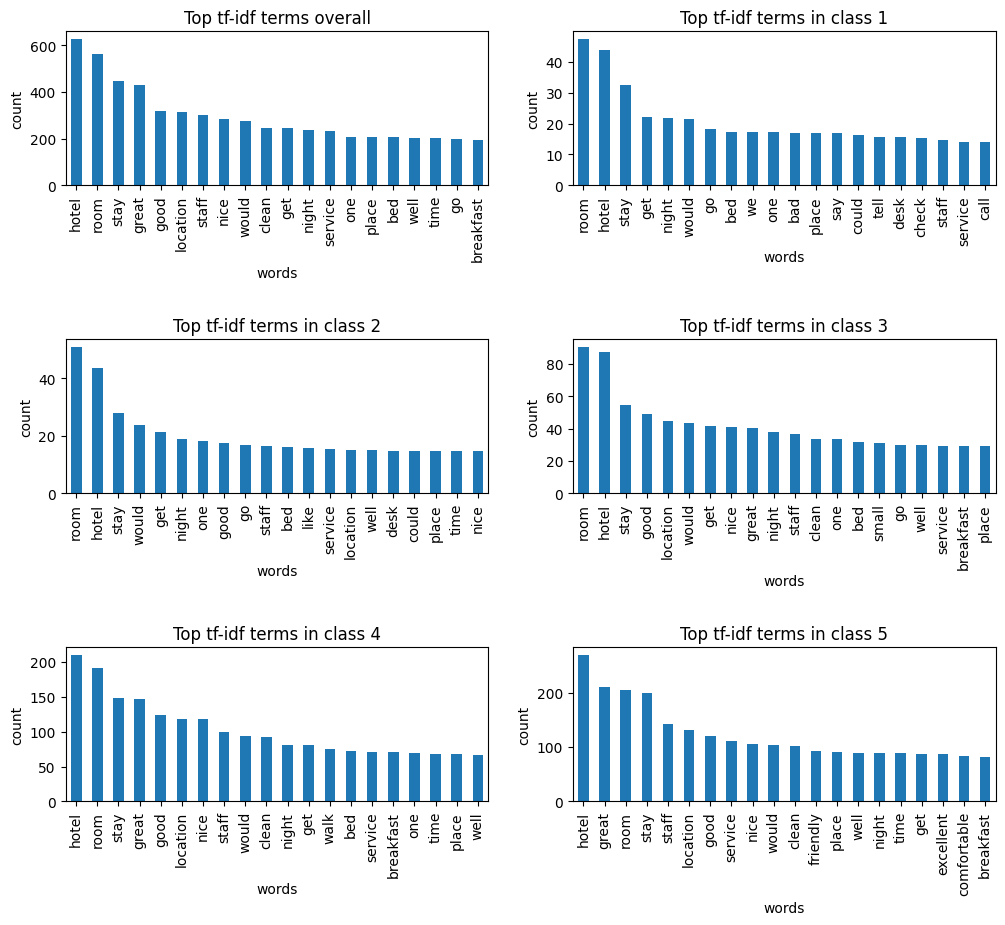

In [14]:
def draw_tfidf_plots():
    plt.figure(figsize=(12, 10)) 
    plt.subplots_adjust(hspace=1)

    # Draw the words with top tf-idf scores for dev set
    plt.subplot(3, 2, 1)
    plt.title("Top tf-idf terms overall")
    vectorizer = TfidfVectorizer()
    tf_idf_matrix = vectorizer.fit_transform(df_dev["text_cleaned"])
    tfidf_scores_df = pd.DataFrame(tf_idf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    scores = tfidf_scores_df.sum(axis=0)
    sorted_words = scores.sort_values(ascending=False)
    plot = sorted_words.head(20).plot.bar()
    plot.set(xlabel="words", ylabel="count")

    # Loop over each class and draw words with the top tf-idf scores
    for i in range(1, 6):
        plt.subplot(3, 2, i+1)
        plt.title(f"Top tf-idf terms in class {i}")
        vectorizer = TfidfVectorizer()
        tf_idf_matrix = vectorizer.fit_transform(df_dev[df_dev["overall"] == i]["text_cleaned"])
        tfidf_scores_df = pd.DataFrame(tf_idf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
        scores = tfidf_scores_df.sum(axis=0)
        sorted_words = scores.sort_values(ascending=False)
        plot = sorted_words.head(20).plot.bar()
        plot.set(xlabel="words", ylabel="count")

    plt.show()

draw_tfidf_plots()
    

Unfortunately, the tf-idf charts are quite similar to those of the most frequent words. They display the positive sentiment very clearly but not as well for the negative classes. Classes 1 and 2 do not have any predictive word apart from "bad".

Finally, we analyze the reviews' lengths to see if there are any useful insights for our task.

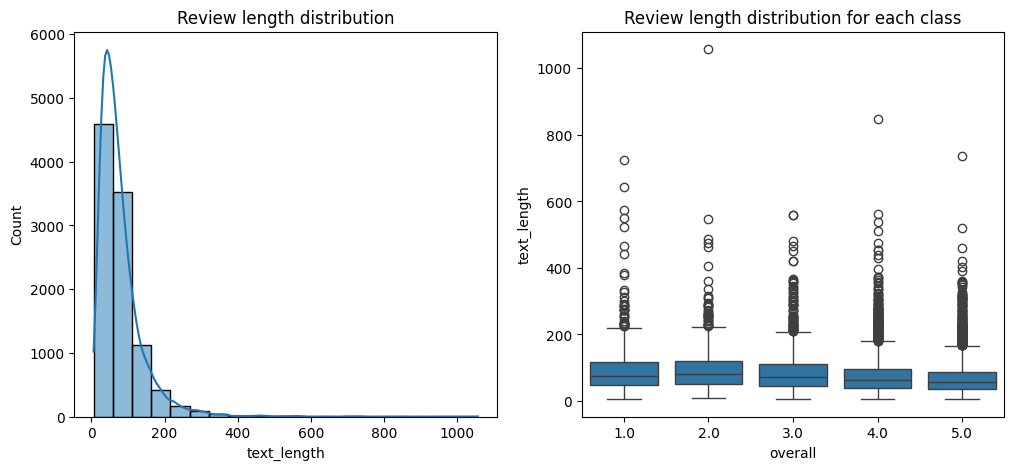

In [15]:
# Function to draw the plots related to review length
def draw_review_length_plots():
    warnings.filterwarnings("ignore")
    df_dev["text_length"] = df_dev["text_cleaned"].apply(lambda x: len(x.split(" ")))

    plt.figure(figsize=(12, 5)) 

    plt.subplot(1, 2, 1)
    plt.title("Review length distribution")
    plt1 = sns.histplot(df_dev["text_length"], bins=20, kde=True)

    plt.subplot(1, 2, 2)
    plt.title("Review length distribution for each class")
    plt2 = sns.boxplot(x="overall", y="text_length", data=df_dev)
    plt.show()

    warnings.filterwarnings("always")

draw_review_length_plots()

Most of the reviews seem to be under 200 words. Surprisingly, all 5 classes have fairly similar distribution of review length so this might not be a useful feature for our task.

### 3. Preprocessing

The preprocessing steps are as follows:
1. Convert overall scores to sentiments: We will group classes 4 and 5 to "positive", and 1 and 2 to "negative" group. Class 3, despite showing a tendency of being positive, will be dropped from the dataset because it is a middle score and might introduce noises to our data if we put it to either group.

2. Convert reviews from raw text to numeric feature: We use word2vec to convert each word to a vector (Rehurek, 2024). To represent a review, we will calculate the vectors for each word in that review and take the average vector as the final result.

3. Raw text processing: We will test out the models' performance on three techniques (stop-word removal, lemmatisation, and lowercasing) separately and together to see which pipeline produces the best results.

4. Since there is a high imbalance between the positive and negative classes, we will also implement the oversampling method with SMOTE (Satpathy, 2023) to see if it improves the performance.


In [16]:
# Convert overall score to sentiment
def score_to_sentiment(score):
    if score < 3:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"
    
df["sentiment"] = df["overall"].apply(score_to_sentiment)
df = df[df["sentiment"] != "neutral"]

# Reset index after dropping the rows
df = df.reset_index(drop=True)

df.head(5)

,overall,text,text_cleaned,sentiment
0,1.0,“Horrible experience” First of all we got ther...,horrible experience first get room book pay we...,negative
1,1.0,“Stay Away” Found Racist graffiti in the room....,stay away find racist graffiti room request ch...,negative
2,4.0,“Great location and service” Close to Union Sq...,great location service close union square hote...,positive
3,2.0,“I will never go back here again!” I had a bad...,never go back bad vibe place moment walk main ...,negative
4,1.0,“Ripped off our VISA card after departure” Aft...,rip visa card departure receive final bill lea...,negative


In [17]:
# Convert raw text to vectors using gensim word2vec

# Tokenize each review to a list of words
def tokenize(text):
    return text.split(" ")

df["text_tokenized"] = df["text_cleaned"].apply(tokenize)

model = Word2Vec(df["text_tokenized"].to_list(), min_count=1)

# Get the vector for each review
def text_to_vector(token_list):
    return sum(model.wv[token] for token in token_list) / len(token_list)

df["text_vectorized"] = df["text_tokenized"].apply(text_to_vector)
df.head(5)

,overall,text,text_cleaned,sentiment,text_tokenized,text_vectorized
0,1.0,“Horrible experience” First of all we got ther...,horrible experience first get room book pay we...,negative,"[horrible, experience, first, get, room, book,...","[-0.1996909, 0.12444155, 0.60729563, -0.075764..."
1,1.0,“Stay Away” Found Racist graffiti in the room....,stay away find racist graffiti room request ch...,negative,"[stay, away, find, racist, graffiti, room, req...","[-0.31649157, 0.24170773, 0.32364634, -0.03526..."
2,4.0,“Great location and service” Close to Union Sq...,great location service close union square hote...,positive,"[great, location, service, close, union, squar...","[-0.54516613, 0.3989831, 0.026211277, -0.24931..."
3,2.0,“I will never go back here again!” I had a bad...,never go back bad vibe place moment walk main ...,negative,"[never, go, back, bad, vibe, place, moment, wa...","[-0.15727788, 0.13480966, 0.07212008, -0.18779..."
4,1.0,“Ripped off our VISA card after departure” Aft...,rip visa card departure receive final bill lea...,negative,"[rip, visa, card, departure, receive, final, b...","[0.13289298, 0.4836075, 0.24853678, -0.0771499..."


In [18]:
# Split the data to training, development, and test sets
df_train = df.loc[0:9999]
df_dev = df.loc[10000:19999]
df_test = df.loc[20000:]

### 4. Selecting supervised method for sentiment classification

Since this is the binary classification class, I will test out the seven most common classifiers for the task:
- Multinomial Naive Bayes
- Random forest
- Logistic regression with l1 penalty
- Logistic regression with l2 penalty
- Support vector machine
- K-nearest neighbours
- Multilayer perceptron.

Data splitting strategy:
- Get the first 10000 samples for the train set, the next 10000 samples for the development set, and the remaining (roughly 5000 samples) for the test set.
- Do 10-fold cross validation on the combined train and development sets to compare the models (I already confirmed with the lecturer about this) and use the test set as the final measurement to see how the best models perform on unseen data. I decided to combine the train and development sets for experiment to make use of all of the available data.
- The data splits during the cross validation process use the stratified method from sklearn to ensure the same ratio of 2 classes in each set after splitting.

Evaluation metrics: I will use the f1 score to because it takes into account the performance of the models for both classes and does not create misleading results like accuracy when there is high class imbalance (Huilgol, 2019). In addition, I use the weighted average for the score since it weighs the proportion of each class and uses that in the average calculation (EvidentlyAITeam, 2024).

In [19]:
# Get the X's and y's from the dataframes
X_train = df_train["text_vectorized"].to_list()
y_train = df_train["sentiment"].to_list()

X_dev = df_dev["text_vectorized"].to_list()
y_dev = df_dev["sentiment"].to_list()

X_test = df_test["text_vectorized"].to_list()
y_test = df_test["sentiment"].to_list()

In [20]:
# Check the number of samples for each class --> high imbalance
df["sentiment"].value_counts()

sentiment
positive    21946
negative     3974
Name: count, dtype: int64

In [21]:
# Function to perform k-fold cross validation
def perform_k_fold_val(X, y, k, algorithm, oversampling=False):
    # Define the k-fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)

    # Define metrics dict to store results
    metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
    }

    # Record the start time
    start_time = time.time()

    for train_index, dev_index in skf.split(X, y):
        # Get the split train and dev sets
        X_train, y_train = X[train_index], y[train_index]
        X_dev, y_dev = X[dev_index], y[dev_index]

        # Oversample the train set
        if oversampling:
            oversample = SMOTE()
            X_train, y_train = oversample.fit_resample(X_train, y_train)

        # Create the model based on selected algorithm and train on the train set
        # Multinomial Naive Bayes
        if algorithm == "mnb":
            clf = Pipeline([
                ("scaler", MinMaxScaler()),
                ("clf", MultinomialNB()),
            ])
        # Random forest
        elif algorithm == "rf":
            clf = RandomForestClassifier(max_depth=100, random_state=0)
        # Logistic regression
        elif algorithm == "lr-l1":
            clf = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l1")
        elif algorithm == "lr-l2":
            clf = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l2")
        # Support vector machine
        elif algorithm == "svm":
            clf = make_pipeline(StandardScaler(), SVC(gamma="auto"))
        # K-nearest neighbours
        elif algorithm == "knn":
            clf = KNeighborsClassifier(n_neighbors=5)
        elif algorithm == "mlp":
            clf = MLPClassifier(random_state=1, max_iter=300)

        # Train on the train set
        clf.fit(X_train, y_train)

        # Predict on dev set
        y_pred = clf.predict(X_dev)

        metrics["accuracy"].append(accuracy_score(y_dev, y_pred))
        metrics["precision"].append(precision_score(y_dev, y_pred, average="weighted"))
        metrics["recall"].append(recall_score(y_dev, y_pred, average="weighted"))
        metrics["f1"].append(f1_score(y_dev, y_pred, average="weighted")) 

    # Record the end time
    end_time = time.time()

    # Print results
    print("_ Algorithm: ", algorithm)
    for metric in metrics.keys():
        print(f"{metric} score: {sum(metrics[metric]) / len(metrics[metric])}")
    print(f"Executed time: {end_time - start_time}s")
    print()

#### 4.1 Test the models with only lowercasing method

In [22]:
warnings.filterwarnings("ignore")

df_train_dev = df.loc[0:19999]

# Process the text with lowercasing
print("Processing text...")
texts_cleaned = [clean_text(text, lowercase=True) for text in tqdm(df_train_dev["text"].to_list())]

# Tokenize 
tokens = [tokenize(text) for text in texts_cleaned]

# Convert text to vectors
model = Word2Vec(tokens, min_count=1)
vectors = [text_to_vector(token) for token in tokens]

# Prepare data for cross validation
X = np.array(vectors)
y = np.array(df_train_dev["sentiment"].to_list())

algorithms = ["mnb", "rf", "lr-l1", "lr-l2", "svm", "knn", "mlp"]
for algo in algorithms:
    perform_k_fold_val(X=X, y=y, k=10, algorithm=algo)

warnings.filterwarnings("always")

Processing text...


100%|██████████| 20000/20000 [00:09<00:00, 2177.74it/s]


_ Algorithm:  mnb
accuracy score: 0.8469999999999998
precision score: 0.717409
recall score: 0.8469999999999998
f1 score: 0.7768370330265294
Executed time: 0.24479174613952637s

_ Algorithm:  rf
accuracy score: 0.9285
precision score: 0.9253402353393524
recall score: 0.9285
f1 score: 0.9245610885534867
Executed time: 106.34452199935913s

_ Algorithm:  lr-l1
accuracy score: 0.94725
precision score: 0.946206904321038
recall score: 0.94725
f1 score: 0.9465075705294488
Executed time: 17.93264102935791s

_ Algorithm:  lr-l2
accuracy score: 0.9472000000000002
precision score: 0.9460600042643694
recall score: 0.9472000000000002
f1 score: 0.9463406934403368
Executed time: 12.46826696395874s

_ Algorithm:  svm
accuracy score: 0.9464499999999999
precision score: 0.9449401629898949
recall score: 0.9464499999999999
f1 score: 0.9451243841919645
Executed time: 31.141192197799683s

_ Algorithm:  knn
accuracy score: 0.9186499999999999
precision score: 0.9141446105683417
recall score: 0.918649999999999

From the performance list, we obserive that Multinominal Naive Bayes is the fastest but also the worst with only 78% in F1 score. The top performers are logistic regression (with either l1 or l2 penalty), support vector machine, and multilayer perceptron with roughly 94% score. However, the multilayer perceptron might be a less ideal candidate since its execution time is significantly longer than the others.

#### 4.2 Test the models with only lemmatisation method

In [23]:
warnings.filterwarnings("ignore")

df_train_dev = df.loc[0:19999]

# Process the text with lemmatisation
print("Processing text...")
texts_cleaned = [clean_text(text, lemmatize=True) for text in tqdm(df_train_dev["text"].to_list())]

# Tokenize 
tokens = [tokenize(text) for text in texts_cleaned]

# Convert text to vectors
model = Word2Vec(tokens, min_count=1)
vectors = [text_to_vector(token) for token in tokens]

# Prepare data for cross validation
X = np.array(vectors)
y = np.array(df_train_dev["sentiment"].to_list())

algorithms = ["mnb", "rf", "lr-l1", "lr-l2", "svm", "knn", "mlp"]
for algo in algorithms:
    perform_k_fold_val(X=X, y=y, k=10, algorithm=algo)

warnings.filterwarnings("always")

Processing text...


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [06:57<00:00, 47.92it/s]


_ Algorithm:  mnb
accuracy score: 0.8469999999999998
precision score: 0.717409
recall score: 0.8469999999999998
f1 score: 0.7768370330265294
Executed time: 0.22336578369140625s

_ Algorithm:  rf
accuracy score: 0.92895
precision score: 0.9260412036725623
recall score: 0.92895
f1 score: 0.924599581674277
Executed time: 107.03173589706421s

_ Algorithm:  lr-l1
accuracy score: 0.9473999999999998
precision score: 0.9461352448603704
recall score: 0.9473999999999998
f1 score: 0.9464497801948559
Executed time: 13.64418911933899s

_ Algorithm:  lr-l2
accuracy score: 0.9477
precision score: 0.9464089598235859
recall score: 0.9477
f1 score: 0.946728351876797
Executed time: 10.626219987869263s

_ Algorithm:  svm
accuracy score: 0.94795
precision score: 0.9465311274273605
recall score: 0.94795
f1 score: 0.9466492717395381
Executed time: 30.76372194290161s

_ Algorithm:  knn
accuracy score: 0.9211
precision score: 0.9169726911250959
recall score: 0.9211
f1 score: 0.916317696138257
Executed time: 0.

Using lemmatisation also yields very similar result to that from lowercasing as we still have the same top performers with 94% in F1 score.

#### 4.3 Test the models with only stop-word removal method

In [24]:
warnings.filterwarnings("ignore")

df_train_dev = df.loc[0:19999]

# Process the text with stop words removal
texts_cleaned = [clean_text(text, remove_stopwords=True) for text in tqdm(df_train_dev["text"].to_list())]

# Tokenize 
tokens = [tokenize(text) for text in texts_cleaned]

# Convert text to vectors
model = Word2Vec(tokens, min_count=1)
vectors = [text_to_vector(token) for token in tokens]

# Prepare data for cross validation
X = np.array(vectors)
y = np.array(df_train_dev["sentiment"].to_list())

algorithms = ["mnb", "rf", "lr-l1", "lr-l2", "svm", "knn", "mlp"]
for algo in algorithms:
    perform_k_fold_val(X=X, y=y, k=10, algorithm=algo)

warnings.filterwarnings("always")

100%|██████████| 20000/20000 [00:10<00:00, 1962.03it/s]


_ Algorithm:  mnb
accuracy score: 0.8470499999999997
precision score: 0.732744888394197
recall score: 0.8470499999999997
f1 score: 0.7769577426858055
Executed time: 0.2158341407775879s

_ Algorithm:  rf
accuracy score: 0.9356500000000001
precision score: 0.9331705712491924
recall score: 0.9356500000000001
f1 score: 0.933035398699313
Executed time: 114.32947206497192s

_ Algorithm:  lr-l1
accuracy score: 0.94665
precision score: 0.9455127084336773
recall score: 0.94665
f1 score: 0.9458045787789097
Executed time: 27.398504972457886s

_ Algorithm:  lr-l2
accuracy score: 0.9467500000000001
precision score: 0.9455499643806645
recall score: 0.9467500000000001
f1 score: 0.9458559522134733
Executed time: 10.887059926986694s

_ Algorithm:  svm
accuracy score: 0.9457000000000001
precision score: 0.9442473072912675
recall score: 0.9457000000000001
f1 score: 0.9444337195766958
Executed time: 29.94442915916443s

_ Algorithm:  knn
accuracy score: 0.92545
precision score: 0.921821951253933
recall sco

Using only top-word removal method also yields similar results.

#### 4.4 Test the models with lowercasing + lemmatisation + stop-word removal

In [25]:
# Perform 10-fold cross-validation on selected algorithms with combined methods of lowercasing, lemmatisation and stop-word removal
warnings.filterwarnings("ignore")

df_train_dev = df.loc[0:19999]
X = np.array(df_train_dev["text_vectorized"].to_list())
y = np.array(df_train_dev["sentiment"].to_list())

algorithms = ["mnb", "rf", "lr-l1", "lr-l2", "svm", "knn", "mlp"]
for algo in algorithms:
    perform_k_fold_val(X=X, y=y, k=10, algorithm=algo)

warnings.filterwarnings("always")

_ Algorithm:  mnb
accuracy score: 0.8470999999999999
precision score: 0.7480807767883941
recall score: 0.8470999999999999
f1 score: 0.7770784523450815
Executed time: 0.37464094161987305s

_ Algorithm:  rf
accuracy score: 0.9414
precision score: 0.9394441971698642
recall score: 0.9414
f1 score: 0.9389842505480275
Executed time: 119.46058392524719s

_ Algorithm:  lr-l1
accuracy score: 0.9522499999999999
precision score: 0.9512603890419064
recall score: 0.9522499999999999
f1 score: 0.9514578816612881
Executed time: 15.54881477355957s

_ Algorithm:  lr-l2
accuracy score: 0.95185
precision score: 0.9508181590867704
recall score: 0.95185
f1 score: 0.9510407763350095
Executed time: 11.458770275115967s

_ Algorithm:  svm
accuracy score: 0.9520999999999997
precision score: 0.9509391201522014
recall score: 0.9520999999999997
f1 score: 0.9510041331227519
Executed time: 27.000113010406494s

_ Algorithm:  knn
accuracy score: 0.9344000000000001
precision score: 0.9318011199742064
recall score: 0.934

By combining the three methods, this time both logistic regression and support vector machine has slightly improved with 95% F1 score at the top. This combined method is therefore the best because:
- Lowercasing helps remove duplications between capitalized and non-capitalized words. For our task, these words typically do not have difference in meaning and lowercasing helps simplify the input features.
- Lemmatisation involves reducing a word to its root form (best --> good) and is better than stemming in general because it does not lose information by simply chopping off the words (Srinidhi, 2023). This process also helps simplify and reduces the size of our vocabulary.
- Stop-word removal: Stop words are common words in conversation that serves no important purposes for sentiment analysis because they have a neutral tone. Removing them also helps reduce the vocabulary size and noises in our dataset.

#### 4.5 Test the models with oversampling method

In [26]:
# Perform 10-fold cross-validation on selected algorithms with oversampling
warnings.filterwarnings("ignore")

df_train_dev = df.loc[0:19999]
X = np.array(df_train_dev["text_vectorized"].to_list())
y = np.array(df_train_dev["sentiment"].to_list())

algorithms = ["mnb", "rf", "lr-l1", "lr-l2", "svm", "knn", "mlp"]
for algo in algorithms:
    perform_k_fold_val(X=X, y=y, k=10, algorithm=algo, oversampling=True)

warnings.filterwarnings("always")

_ Algorithm:  mnb
accuracy score: 0.8736
precision score: 0.9135865847565272
recall score: 0.8736
f1 score: 0.8847489300190361
Executed time: 3.0514349937438965s

_ Algorithm:  rf
accuracy score: 0.9323
precision score: 0.9346966804118766
recall score: 0.9323
f1 score: 0.933282618414083
Executed time: 212.952388048172s

_ Algorithm:  lr-l1
accuracy score: 0.9296
precision score: 0.942280112735842
recall score: 0.9296
f1 score: 0.9332064874450298
Executed time: 22.894049644470215s

_ Algorithm:  lr-l2
accuracy score: 0.9300999999999998
precision score: 0.9427934453032686
recall score: 0.9300999999999998
f1 score: 0.9336908247613518
Executed time: 19.107240915298462s

_ Algorithm:  svm
accuracy score: 0.94215
precision score: 0.9463386896421419
recall score: 0.94215
f1 score: 0.9436122601822776
Executed time: 79.06076073646545s

_ Algorithm:  knn
accuracy score: 0.8658499999999998
precision score: 0.9144610444966652
recall score: 0.8658499999999998
f1 score: 0.8788420070135423
Executed t

Unfortunately, oversampling does not seem to bring any improvement to our top models. On the contrary, it seems to cause a drop in performance for logistic regression by 1%. Therefore, we will discard this method.

#### 4.6 Use the best model to make predictions on the test set

Based on the above experiment, the best models are either logistic regression or support vector machine using the combination of three processing techniques (lowercasing, lemmatisation, and stop-word removal). However, I will pick logistic regression with the l2 penalty because its execution time is significantly shorter.

Let's use the same methods above to train our best model on the combined train and dev sets to make predictions on the test sets and observe how it performs on unseen data.

In [27]:
# Infer on test set
df_train_dev = df.loc[0:19999]
X = np.array(df_train_dev["text_vectorized"].to_list())
y = np.array(df_train_dev["sentiment"].to_list())
X_test = np.array(df_test["text_vectorized"].to_list())
y_test = np.array(df_test["sentiment"].to_list())

clf = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l2")
clf.fit(X, y)

y_pred = clf.predict(X_test)

metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [], 
    "f1": []
}
metrics["accuracy"].append(accuracy_score(y_test, y_pred))
metrics["precision"].append(precision_score(y_test, y_pred, average="weighted"))
metrics["recall"].append(recall_score(y_test, y_pred, average="weighted"))
metrics["f1"].append(f1_score(y_test, y_pred, average="weighted")) 

# Print results
print("_ Algorithm: logistic regression with l2 penalty")
for metric in metrics.keys():
    print(f"{metric} score: {sum(metrics[metric]) / len(metrics[metric])}")


_ Algorithm: logistic regression with l2 penalty
accuracy score: 0.9537162162162162
precision score: 0.9525805367938381
recall score: 0.9537162162162162
f1 score: 0.9527708235566006


The model yields very similar result with that from the cross validation process with 95% in F1 score. Therefore, it does not seem to have the overfitting problem and is a good candidate from the above options.

### 5. Sentiment classification using VADER lexicon and method

Next, let's see how the pretrained VADER model performs on the development set

In [28]:
warnings.filterwarnings("ignore")

df_dev = df.loc[10000:19999]
y_pred = []
y_dev = df_dev["sentiment"].to_list()
analyser = SentimentIntensityAnalyzer()
for text in df_dev["text_cleaned"]:
    score = analyser.polarity_scores(text)
    if score["pos"] > score["neg"]:
        y_pred.append("positive")
    else:
        y_pred.append("negative")

metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}
metrics["accuracy"].append(accuracy_score(y_dev, y_pred))
metrics["precision"].append(precision_score(y_dev, y_pred, average="weighted"))
metrics["recall"].append(recall_score(y_dev, y_pred, average="weighted"))
metrics["f1"].append(f1_score(y_dev, y_pred, average="weighted")) 

# Print results
for metric in metrics.keys():
    print(f"{metric} score: {sum(metrics[metric]) / len(metrics[metric])}")

warnings.filterwarnings("always")

accuracy score: 0.8931
precision score: 0.89697815664395
recall score: 0.8931
f1 score: 0.8712756833550899


With the F1 score of 87%, it performs quite well though not as good as our top model. For a fair comparison, I will perform the exact cross validation method as above to evaluate VADER.

In [29]:
warnings.filterwarnings("ignore")

def perform_k_fold_val_vader(X, y, k):
    # Define the k-fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)

    # Initialize the model
    analyser = SentimentIntensityAnalyzer()

    # Define metrics dict to store results
    metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
    }

    # Record the start time
    start_time = time.time()

    for train_index, dev_index in skf.split(X, y):
        # Get the split train and dev sets
        X_train, y_train = X[train_index], y[train_index]
        X_dev, y_dev = X[dev_index], y[dev_index]

        # Predict on dev set
        y_pred = []
        for text in X_dev:
            score = analyser.polarity_scores(text)
            if score["pos"] > score["neg"]:
                y_pred.append("positive")
            else:
                y_pred.append("negative")

        metrics = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": []
        }
        metrics["accuracy"].append(accuracy_score(y_dev, y_pred))
        metrics["precision"].append(precision_score(y_dev, y_pred, average="weighted"))
        metrics["recall"].append(recall_score(y_dev, y_pred, average="weighted"))
        metrics["f1"].append(f1_score(y_dev, y_pred, average="weighted")) 

    # Record the end time
    end_time = time.time()

    # Print results
    for metric in metrics.keys():
        print(f"{metric} score: {sum(metrics[metric]) / len(metrics[metric])}")
    print(f"Executed time: {end_time - start_time}s")


df_train_dev = df.loc[10000:19999]
X = np.array(df_train_dev["text_cleaned"].to_list())
y = np.array(df_train_dev["sentiment"].to_list())
perform_k_fold_val_vader(X=X, y=y, k=10)

warnings.filterwarnings("always")

accuracy score: 0.894
precision score: 0.893833484162896
recall score: 0.894
f1 score: 0.8747784432351362
Executed time: 3.8298871517181396s


The F1 score is still at 87% from the cross validation process, so we can conclude that VADER is quite good, but not as good as our top model logistic regression. However, its execution time is a lot faster than our top model.

### 6. Combining VADER with the best classifier

I will implement the stacking method to combine VADER with my logistic regression model (Soni, 2023). The idea behind this technique is to train multiple base models on a specific task, then combine their predictions to train a meta model which produces the final predictions. This technique attempts to reduce the bias and variance by combining the preditive capabilities of various models.

For this specific task, I will use my logistic regression model (with l2 penalty) and VADER as the base models. Then I will experiment with various meta models to see which one produces the best result.

I will the perform the same preprocessing and cross validation steps with some minor tweaks for this method:
- Do the 10-fold cross validation on the combined train and dev sets to evaluate the model's performance:
    - For each fold, the data is split to the train and dev sets.
    - Split the train set to train1 and train2 sets.
    - Train the 2 base models on the train1 set and make predictions on the train2 set.
    - Combine the predictions on the train2 set to train the meta model.
    - Use the meta model to produce the predictions on the dev set. 
- The final best model is then trained on the combined train + dev set and make predictions on the test set to see how it performs on unseen data.

In [30]:
# Split the data
df_train = df.loc[0:9999]
df_dev = df.loc[10000:19999]
df_test = df.loc[20000:]

X_train = np.array(df_train["text_vectorized"].to_list())
y_train = np.array(df_train["sentiment"].to_list())

X_dev = np.array(df_dev["text_vectorized"].to_list())
y_dev = np.array(df_dev["sentiment"].to_list())

X_test = np.array(df_test["text_vectorized"].to_list())
y_test = np.array(df_test["sentiment"].to_list())

In [31]:
# Function to perform cross validation for stacking method
def perform_k_fold_val_stacking(X, y, k, meta_algorithm):
    # Define the k-fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)

    # Define metrics dict to store results
    metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
    }

    # Record the start time
    start_time = time.time()

    for train_index, dev_index in skf.split(X, y):
        # Get the split train and dev sets
        X_train, y_train = X.iloc[train_index], y[train_index]
        X_dev, y_dev = X.iloc[dev_index], y[dev_index]

        # Split the train set further into train_1 and train_2 sets
        X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)


        # Train the 2 base models and make predictions on train_2 set
        base_model_1 = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l2")
        base_model_1.fit(np.array(X_train_1["text_vectorized"].to_list()), y_train_1)
        y_pred_1 = base_model_1.predict(np.array(X_train_2["text_vectorized"].to_list()))

        base_model_2 = SentimentIntensityAnalyzer()
        y_pred_2 = []
        for text in X_train_2["text_cleaned"].to_list():
            score = base_model_2.polarity_scores(text)
            if score["pos"] > score["neg"]:
                y_pred_2.append("positive")
            else:
                y_pred_2.append("negative")
        y_pred_2 = np.array(y_pred_2)
        
        # Convert the predictions (negative and positive) to numbers (0 and 1)
        y_pred_1 = np.array([0 if val == "negative" else 1 for val in y_pred_1])
        y_pred_2 = np.array([0 if val == "negative" else 1 for val in y_pred_2])

        # Combine the 2 predictions as input for the meta model
        X_meta = np.column_stack((y_pred_1, y_pred_2))
        
        # Train the meta model on the combined predictions of train_2 set
        # Multinomial Naive Bayes
        if meta_algorithm == "mnb":
            meta_model = Pipeline([
                ("scaler", MinMaxScaler()),
                ("clf", MultinomialNB()),
            ])
        # Random forest
        elif meta_algorithm == "rf":
            meta_model = RandomForestClassifier(max_depth=100, random_state=0)
        # Logistic regression
        elif meta_algorithm == "lr-l1":
            meta_model = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l1")
        elif meta_algorithm == "lr-l2":
            meta_model = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l2")
        # Support vector machine
        elif meta_algorithm == "svm":
            meta_model = make_pipeline(StandardScaler(), SVC(gamma="auto"))
        # K-nearest neighbours
        elif meta_algorithm == "knn":
            meta_model = KNeighborsClassifier(n_neighbors=5)
        elif meta_algorithm == "mlp":
            meta_model = MLPClassifier(random_state=1, max_iter=300)
        meta_model.fit(X_meta, y_train_2)

        # Use the 2 base models to predict on the val set
        y_val_pred_1 = base_model_1.predict(np.array(X_dev["text_vectorized"].to_list()))
        y_val_pred_2 = []
        for text in X_dev["text_cleaned"].to_list():
            score = base_model_2.polarity_scores(text)
            if score["pos"] > score["neg"]:
                y_val_pred_2.append("positive")
            else:
                y_val_pred_2.append("negative")
        y_val_pred_2 = np.array(y_val_pred_2)

        # Convert the predictions (negative and positive) to numbers (0 and 1)
        y_val_pred_1 = np.array([0 if val == "negative" else 1 for val in y_val_pred_1])
        y_val_pred_2 = np.array([0 if val == "negative" else 1 for val in y_val_pred_2])

        # Combine the predictions of the base models on dev set
        X_val_meta = np.column_stack((y_val_pred_1, y_val_pred_2))

        # Use meta model to output the final predictions
        y_pred = meta_model.predict(X_val_meta)

        # Save results
        metrics["accuracy"].append(accuracy_score(y_dev, y_pred))
        metrics["precision"].append(precision_score(y_dev, y_pred, average="weighted"))
        metrics["recall"].append(recall_score(y_dev, y_pred, average="weighted"))
        metrics["f1"].append(f1_score(y_dev, y_pred, average="weighted")) 
 
    # Record the end time
    end_time = time.time()

    # Print results
    print("_ Algorithm: ", meta_algorithm)
    for metric in metrics.keys():
        print(f"{metric} score: {sum(metrics[metric]) / len(metrics[metric])}")
    print(f"Executed time: {end_time - start_time}s")
    print()


In [32]:
# Test the stacking method with various meta models
warnings.filterwarnings("ignore")

df_train_dev = df.loc[0:19999]

X = df_train_dev[["text_cleaned", "text_vectorized"]]
y = np.array(df_train_dev["sentiment"].to_list())

meta_algorithms = ["mnb", "rf", "lr-l1", "lr-l2", "svm", "knn", "mlp"]
for algo in meta_algorithms:
    perform_k_fold_val_stacking(X=X, y=y, k=10, meta_algorithm=algo)

warnings.filterwarnings("always")

_ Algorithm:  mnb
accuracy score: 0.8469999999999998
precision score: 0.717409
recall score: 0.8469999999999998
f1 score: 0.7768370330265294
Executed time: 29.727272033691406s

_ Algorithm:  rf
accuracy score: 0.9524999999999999
precision score: 0.9515835369718939
recall score: 0.9524999999999999
f1 score: 0.9518453837493844
Executed time: 29.963891983032227s

_ Algorithm:  lr-l1
accuracy score: 0.9523499999999998
precision score: 0.9513413125846488
recall score: 0.9523499999999998
f1 score: 0.9515944157628503
Executed time: 29.40325903892517s

_ Algorithm:  lr-l2
accuracy score: 0.9523499999999998
precision score: 0.9513413125846488
recall score: 0.9523499999999998
f1 score: 0.9515944157628503
Executed time: 29.56174612045288s

_ Algorithm:  svm
accuracy score: 0.9524999999999999
precision score: 0.9515835369718939
recall score: 0.9524999999999999
f1 score: 0.9518453837493844
Executed time: 29.473971128463745s

_ Algorithm:  knn
accuracy score: 0.9422499999999999
precision score: 0.94

Unfortunately, this method does not guarantee an improvement and in our case, the top models still center around 95% F1 score. A suggestion for future improvement would be to increase the number of base models (up to 3-4 for example) to see if we can combine a wider variety or their predictive capabilities.

Random forest seems to give one of the best results for this stage so I will pick it as the best meta model.

### 7. Training and testing the final method

Finally, let's train our best model (logistic regression) and the previous stacking model on the combined train + dev sets and see how they perform on unseen data on the test set

In [33]:
# Logistic regression with l2 penalty's predictions on test set
df_train = df.loc[0:19999]
df_test = df.loc[20000:]

X_train = np.array(df_train["text_vectorized"].to_list())
y_train = np.array(df_train["sentiment"].to_list())
X_test = np.array(df_test["text_vectorized"].to_list())
y_test = np.array(df_test["sentiment"].to_list())

meta_model = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l2")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}
metrics["accuracy"].append(accuracy_score(y_test, y_pred))
metrics["precision"].append(precision_score(y_test, y_pred, average="weighted"))
metrics["recall"].append(recall_score(y_test, y_pred, average="weighted"))
metrics["f1"].append(f1_score(y_test, y_pred, average="weighted")) 

# Print results
for metric in metrics.keys(): 
    print(f"{metric} score: {sum(metrics[metric]) / len(metrics[metric])}")

accuracy score: 0.9537162162162162
precision score: 0.9525805367938381
recall score: 0.9537162162162162
f1 score: 0.9527708235566006


In [34]:
# Stacking model's predictions on test set

# Split to train and test sets
df_train = df.loc[0:19999]
df_test = df.loc[20000:]

# Get the X
X_train = df_train[["text_cleaned", "text_vectorized"]]
y_train = np.array(df_train["sentiment"].to_list())
X_test = df_test[["text_cleaned", "text_vectorized"]]
y_test = np.array(df_test["sentiment"].to_list())

# Split the train set further into train_1 and train_2 sets
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

# Train the 2 base models and make predictions on train_2 set
base_model_1 = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l2")
base_model_1.fit(np.array(X_train_1["text_vectorized"].to_list()), y_train_1)
y_pred_1 = base_model_1.predict(np.array(X_train_2["text_vectorized"].to_list()))

base_model_2 = SentimentIntensityAnalyzer()
y_pred_2 = []
for text in X_train_2["text_cleaned"].to_list():
    score = base_model_2.polarity_scores(text)
    if score["pos"] > score["neg"]:
        y_pred_2.append("positive")
    else:
        y_pred_2.append("negative")
y_pred_2 = np.array(y_pred_2)

# Convert the predictions (negative and positive) to numbers (0 and 1)
y_pred_1 = np.array([0 if val == "negative" else 1 for val in y_pred_1])
y_pred_2 = np.array([0 if val == "negative" else 1 for val in y_pred_2])

# Combine the 2 predictions as input for the meta model
X_meta = np.column_stack((y_pred_1, y_pred_2))

# Train the meta model on the combined predictions of train_2 set
# meta_model = LogisticRegression(random_state=0, max_iter=10000, solver="saga", penalty="l2")
meta_model = RandomForestClassifier(max_depth=100, random_state=0)
meta_model.fit(X_meta, y_train_2)

# Use the 2 base models to predict on the test set
y_test_pred_1 = base_model_1.predict(np.array(X_test["text_vectorized"].to_list()))
y_test_pred_2 = []
for text in X_test["text_cleaned"].to_list():
    score = base_model_2.polarity_scores(text)
    if score["pos"] > score["neg"]:
        y_test_pred_2.append("positive")
    else:
        y_test_pred_2.append("negative")
y_test_pred_2 = np.array(y_test_pred_2)

# Convert the predictions (negative and positive) to numbers (0 and 1)
y_test_pred_1 = np.array([0 if val == "negative" else 1 for val in y_test_pred_1])
y_test_pred_2 = np.array([0 if val == "negative" else 1 for val in y_test_pred_2])

# Combine the predictions of the base models on test set
X_test_meta = np.column_stack((y_test_pred_1, y_test_pred_2))

# Use meta model to output the final predictions
y_pred = meta_model.predict(X_test_meta)

# Print results
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted')}")

Accuracy: 0.9552364864864865
Precision: 0.9541423951818452
Recall: 0.9552364864864865
F1 score: 0.9542427601931415


Both models give very similar results on the test set compared to those from the cross validation step (roughly 95% on F1 score), so we can conclude that they both do not have the overfitting issue and are good final candidates for our sentiment analysis task.

### 8. Reviews aspect prediction

The dataset provided also contains six different aspects including service, cleanliness, value, location, sleep quality, and rooms. When a user gives an overall rating for a review, it might not be clear which aspect they are rating or referring to in the review, so it will be useful to figure how the main aspects hidden in each review.

(Wang et al., 2010) proposes a regression method to solve this problem. Given a text review and its overall score, their method can predict the score for the predefined set of aspects and calculates the importance weight for each aspect contributing to the overall score. The method contains 2 main stages.

The first stage is aspect segmentation where they map each review to the relevant aspects. The paper assumes that we already have a predefined set of aspects, so we can use the six aspects included in our dataset. The stage includes the bootstrapping algorithm as follows (Wang et al., 2010):
- Split each review into sentences.
- Given a few seeded key words for each aspect, calculate the frequency for each of these words in each review.
- Assign the aspect with the most matched keywords to the review. If there is a draw assign multiple aspects.
- Use the Chi-Square test to calculate the dependencies between each word and aspect, then assign the words with the top scores to their corresponding aspects.
- Repeat until the keyword list stops changing or reaching the predefined number of steps.

At this point, we have figured out the main aspects hidden in each review, the next stage is to use a regression model to predict the score and importance weight for each of these aspect. The authors made some important assumptions following this stage (Wang et al., 2010):
- The user first chooses the aspects on which she wants to write the review.
- The user gives a rating for each chosen aspect based on the sentiments of the words she used in the review.
- The overall score is the weighted sum of the aspects' individual scores.

The authors then proceeded to form an equation to map the overall score with the ratings and weights for each aspect, and implemented a regression model on that equation to predict the weights and scores for any given text review (in section 4.2).

In conclusion, I think this method might be useful for our task since we already have the text review and the given set of aspects. The above technique will provide us with two important pieces of information:
- Which aspects are being mentioned in each review.
- What is the rating score and contributing weight for each mentioned aspect in that review.

### 9. References

GEEKSFORGEEKS. 2024. Understanding TF-IDF (Term Frequency-Inverse Document Frequency) [Online]. Available: https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/ [Accessed 1 April 2024].

REHUREK, R. 2024. Word2vec embeddings [Online]. Available: https://radimrehurek.com/gensim/models/word2vec.html [Accessed 1 April 2024].

SATPATHY, S. 2023. SMOTE for Imbalanced Classification with Python [Online]. Available: https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/ [Accessed 1 April 2024].

HUILGOL, P. 2019. Accuracy vs. F1-Score [Online]. Available: https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2 [Accessed 1 April 2024].

EVIDENTLYAITEAM. 2024. Accuracy, precision, and recall in multi-class classification [Online]. Available: https://www.evidentlyai.com/classification-metrics/multi-class-metrics [Accessed 1 April 2024].

SRINIDHI, S. 2023. Lemmatization in Natural Language Processing (NLP) and Machine Learning [Online]. Available: https://builtin.com/machine-learning/lemmatization [Accessed 1 April 2024].

SONI, B. 2023. Stacking to Improve Model Performance: A Comprehensive Guide on Ensemble Learning in Python [Online]. Available: https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28 [Accessed 1 April 2024].

WANG, H., LU, Y. & ZHAI, C. Latent aspect rating analysis on review text data: a rating regression approach.  Proceedings of the 16th ACM SIGKDD international conference on Knowledge discovery and data mining, 2010. 783-792.